## Intro to dataset
The problem here is about classification, outcome is the binary variable. The variables in data set are as follows:-
1. Number of times pregnant
2. Plasma glucose concentration a 2 hours in an oral glucose tolerance test
3. Diastolic blood pressure (mm Hg)
4. Triceps skin fold thickness (mm)
5. 2-Hour serum insulin (mu U/ml)
6. Body mass index (weight in kg/(height in m)^2)
7. Diabetes pedigree function
8. Age (years)
9. Class variable (0 or 1)

#### Problem Statement: 
Given a set of eight medical characteristics about a patients, predict whether or not the patient has diabetes. To accomplish this task, we will use a set of real-world data collected on females 21 years of age and over collected by a national health institution in the United States.

## Approach
The goal is to implement the Bayesian form of Logistic Regression. This is done by setting up a model relating the inputs (features) to the outputs (response) and then sampling from the posteriors for the model parameters. In the case of logistic regression, the model parameters are the weights on the features, explained in detail later. The end result is a distribution (trace) of all the model parameter values that are drawn from the posterior. The procedure will be implemented in the Python library PyMC3, which is used for Bayesian inference and has a number of Markov Chain Monte Carlo implementations for sampling from the posterior. The basic outline is as follows:

1. Exploratory Data Analysis -> 
2. Split data into training and testing sets (568+200) -> 
3. Establish naive benchmark (a very naive approach to check if ML is right approach to do or no) -> 
4. Evaluate several standard machine learning approaches for performance (we are not implimenting hyperparameter tuning here, doing that might make our model work better) -> 
        4.1 Logisctic regression
        4.2 Random forest
        4.3 SVM classifier
#### BAYESIAN CLASSIFIER    
5. Define the model formula and set up the model using the pm.GLM.from_formula function -> 
6. Sample from the posterior for the model parameters using the pm.sample function which will use the NUTS sampler -> 
7. Interpret the parameter traces -> 
8. Summary statistics
9. Model effects of variables

10. Use the parameter traces to make predictions -> 
        10.1 Calculate predictions
        10.2 Exampne specific cases
11. Compare the performance of the logistic regression model to the standard machine learning methods -> 

NOTE: the complete descriptionof MCMC, models that we are implimenting are defined in the later section. 

NOTE: benefits of Bayesian models are not in their accuracy but interpretability.
**Important point to note is that the outcome is not going to present binary vaues, ie 0 for no diabeties and 1 for diabeties, rather it will be probability**

In [336]:
! pip install plotly

In [337]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline 

import seaborn as sns

import pymc3 as pm
from statsmodels.formula.api import glm as glm_sm
import statsmodels.api as sm
from pandas.plotting import scatter_matrix
import theano


In [338]:
from IPython.core.pylabtools import figsize
import matplotlib.lines as mlines

import seaborn as sns

# Standard machine learning models
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Scikit-learn utilities
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score, roc_curve

import itertools

pd.options.mode.chained_assignment = None

import matplotlib as mpl

from warnings import filterwarnings
filterwarnings('ignore')

In [339]:
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
py.init_notebook_mode(connected=True)

In [426]:
data = pd.read_csv(r'diabetes.csv')
data.head()

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1

In [341]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
Pregnancies                 768 non-null int64
Glucose                     768 non-null int64
BloodPressure               768 non-null int64
SkinThickness               768 non-null int64
Insulin                     768 non-null int64
BMI                         768 non-null float64
DiabetesPedigreeFunction    768 non-null float64
Age                         768 non-null int64
Outcome                     768 non-null int64
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [342]:
data.describe()

Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.369578   31.972618      19.355807      15.952218  115.244002   
min       0.000000    0.000000       0.000000       0.000000    0.000000   
25%       1.000000   99.000000      62.000000       0.000000    0.000000   
50%       3.000000  117.000000      72.000000      23.000000   30.500000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean    31.992578                  0.471876   33.240885    0.348958  
std      7.884160                  0.331329   11.760232    0.476951  
min      0.000000                  0.078000   21.000000    0.000000  
25%     27.300000                  0.243750   24.000000    0.000000  
50%     32.000000                  0.372500   29.000000    0.000000  
75%     36.600000                  0.626250   41.000000    1.000000  
max     67.100000                  2.420000   81.000000    1.000000

### Missing Values
#### There are missing values which are represented by 0 and are not possible. Repalcing the missing values of each column with the median values

In [343]:
data['Glucose'] = data['Glucose'].replace({0: data['Glucose'].median()})
data['BloodPressure'] = data['BloodPressure'].replace({0: data['BloodPressure'].median()})
data['SkinThickness'] = data['SkinThickness'].replace({0: data['SkinThickness'].median()})
data['Insulin'] = data['Insulin'].replace({0: data['Insulin'].median()})
data['BMI'] = data['BMI'].replace({0: data['BMI'].median()})


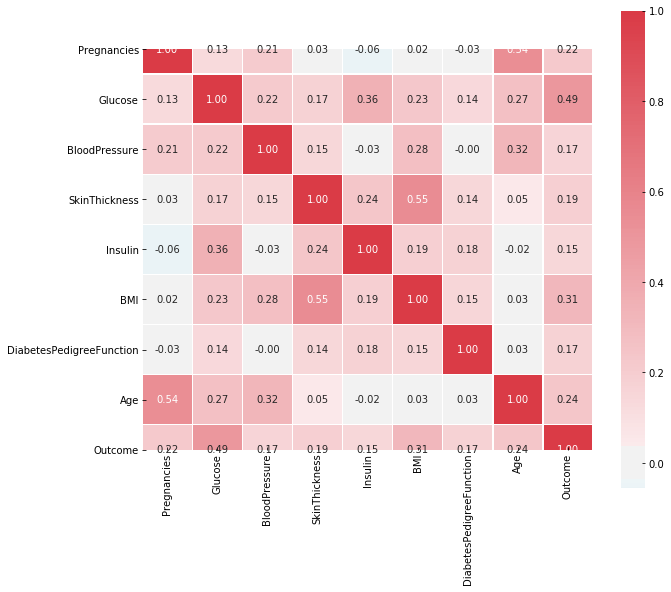

In [344]:
correlations = data.corr()
## Create color map ranging between two colors
cmap = sns.diverging_palette(220, 10, as_cmap=True)
fig, ax = plt.subplots(figsize=(10, 10))
fig = sns.heatmap(correlations, cmap=cmap, vmax=1.0, center=0, fmt='.2f',square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .75})
fig.set_xticklabels(fig.get_xticklabels(), rotation = 90, fontsize = 10)
fig.set_yticklabels(fig.get_yticklabels(), rotation = 0, fontsize = 10)
plt.tight_layout()
plt.show()


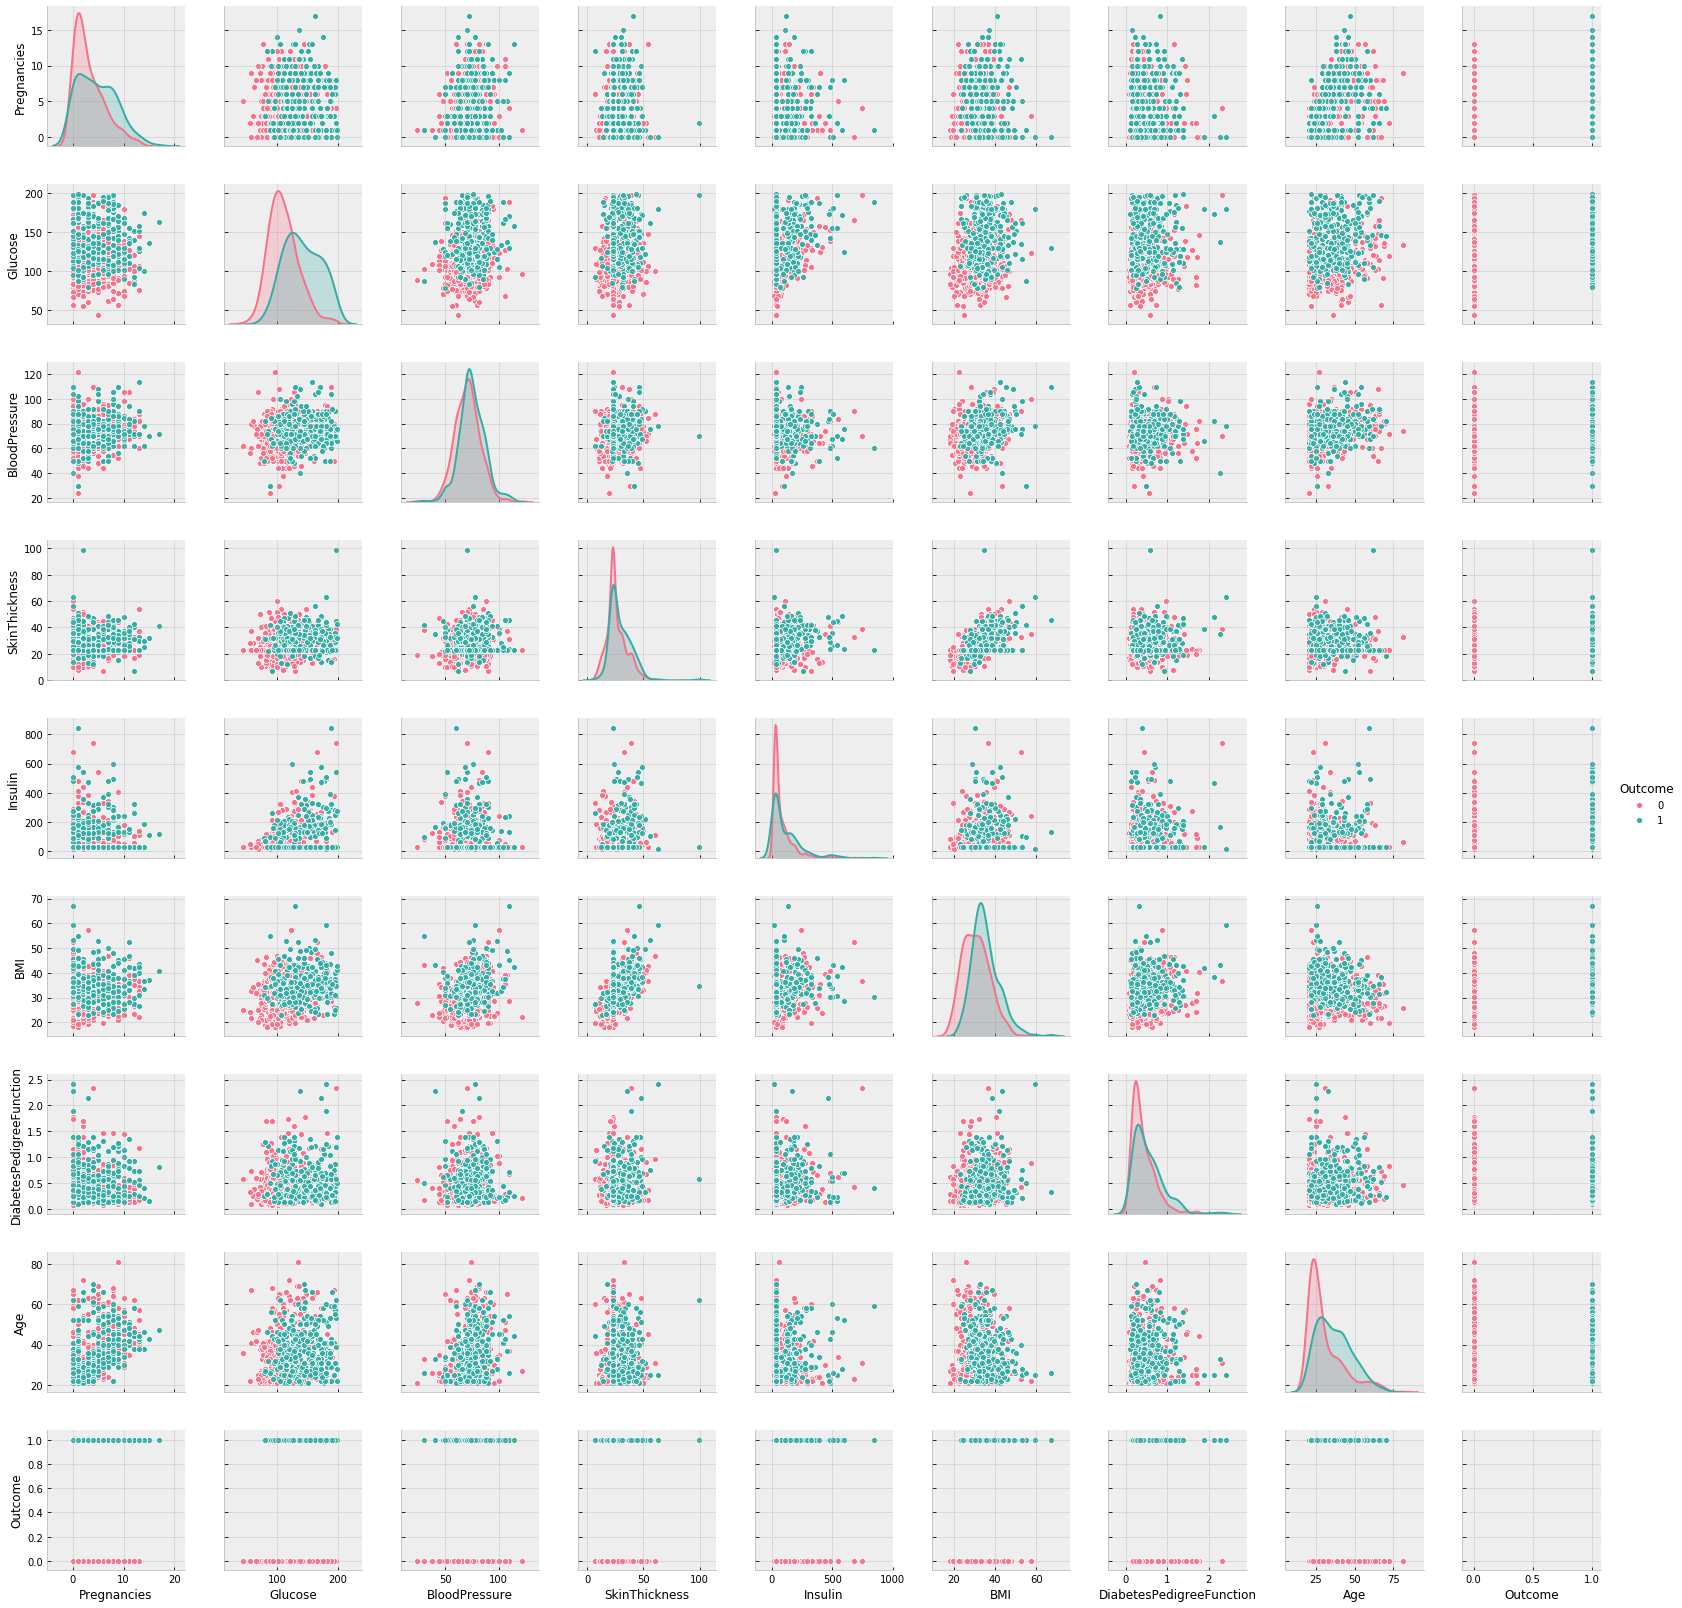

In [345]:
g = sns.pairplot(data, hue="Outcome", palette="husl")

### training and test data

In [346]:
# Extract the features and the labels
features = data.drop(columns='Outcome')
labels = data.Outcome

# Split into training and testing set using 200 observations for testing
X, X_test, y, y_test = train_test_split(features, labels, test_size=200, random_state = 50)

print(X.shape)
print(X_test.shape)

(568, 8)
(200, 8)


In [347]:
# Visualize a confusion matrix as a plot given the confusion matrix
def plot_confusion_matrix(cm, classes = ['No Diabetes', 'Diabetes'], title='Diabetes Confusion matrix',
                          cmap=plt.cm.Reds):
    
    # Display the matrix in text form
    print('Confusion matrix')
    print(cm)
    figsize(10, 10)
    
    # Show the matrix using the imshow functionality
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 20)
    
    # Tick marks show classes
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 12)
    plt.yticks(tick_marks, classes, rotation = 90, size = 12)

    # Formatting for text labels on plot
    fmt1 = 's'
    fmt2 = 'd'
    thresh = cm.max() / 2.
    
    # Four types of classifications
    types = [['True Negative', 'False Positive'],
             ['False Negative', 'True Positive']]
    
    
    # Add the actual numbers and the types onto the heatmap plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        print(i,j,format(types[i][j], fmt1), format(cm[i, j], fmt2))
        plt.text(j, i + .5, format(types[i][j], fmt1),
                 horizontalalignment="center", size = 10,
                 color="white" if cm[i, j] > thresh else "black")
        
        plt.text(j, i-0.1 , format(cm[i, j], fmt2),
                 horizontalalignment="center", size = 24,
                 color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label', size = 16)
    plt.xlabel('Predicted Label', size = 16)

In [348]:
def calc_metrics(predictions, y_test):
    accuracy = np.mean(predictions == y_test)
    f1_metric = f1_score(y_test, predictions)

    print('Accuracy of Model: {:.2f}%'.format(100 * accuracy))
    print('F1 Score of Model: {:.4f}'.format(f1_metric))

In [349]:
# Determine the roc curve and the auc and display

def calc_roc(probs, y_test):
    # Calculate the area under the roc curve
    auc = roc_auc_score(y_test, probs)

    # Calculate metrics for the roc curve
    fpr, tpr, thresholds = roc_curve(y_test, probs)

    plt.style.use('bmh')
    plt.figure(figsize = (8, 8))

    # Plot the roc curve
    plt.plot(fpr, tpr, 'b')
    plt.xlabel('False Positive Rate', size = 16)
    plt.ylabel('True Positive Rate', size = 16)
    plt.title('Receiver Operating Characteristic Curve, AUC = %0.4f' % auc, 
            size = 18)

## Naive baseline
To access even if ML is applicable to our problem, we are creating a baseline withwhcihc we will be comparing our results. For classification, a simple naive baseline is to predict the most common class in trianing data for all testing observations. If our model can't beat this performance then we shoudl consider come other approach. 

In [350]:
y_test.value_counts()

0    127
1     73
Name: Outcome, dtype: int64

In [351]:
types = [['True Negative', 'False Positive'],
             ['False Negative', 'True Positive']]
    
baseline_pred = [0 for _ in range(len(y_test))]
calc_metrics(baseline_pred, y_test)
cm = confusion_matrix(y_test, baseline_pred)
#print(cm)
#print(types)

Accuracy of Model: 63.50%
F1 Score of Model: 0.0000


This means if your model can't have accuracy more than 63.5%, then we should choose another model. (not the best wayof doing this). In the next step we are comparing the performance of diffrent ML. 
How? By comparing their AUC(area under the curve)-ROC(receiver operating characteristics) curve, this is most important characteristic for checking any classification model performance. 
ROC is a probability curve and AUC represents degree or measure of separability. Higher the AUC, better the model in predicting 0 as 0 and 1 as 1. NOTE: see the function calc_roc how we are plotting the curve.

## Logistic Regression

In [352]:
lr = LogisticRegressionCV(Cs= 20, cv = 3, scoring = 'f1', 
                          penalty = 'l2', random_state = 42)
lr.fit(X, y)

# Make predictions and evaluateing that(f score and accuracy)
lr_pred = lr.predict(X_test)
calc_metrics(lr_pred, y_test)

Accuracy of Model: 73.00%
F1 Score of Model: 0.5574


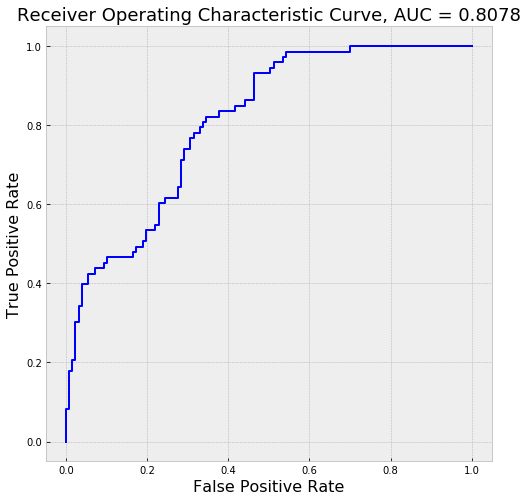

In [353]:
lr_pred_proba = lr.predict_proba(X_test)[:, 1]
calc_roc(lr_pred_proba, y_test)

# Random forest

In [354]:
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X, y)

# Evaluate predictions
rf_pred = rf.predict(X_test)
calc_metrics(rf_pred, y_test)

Accuracy of Model: 72.50%
F1 Score of Model: 0.5600


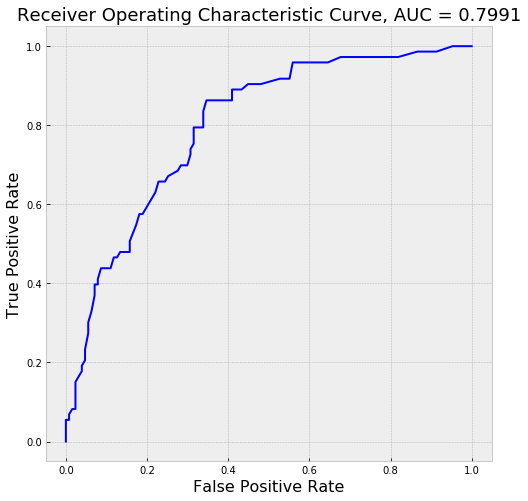

In [355]:
# ROC for random forest
rf_pred_proba = rf.predict_proba(X_test)[:, 1]
calc_roc(rf_pred_proba, y_test)

## SVM (Support Vector Machine Classifier)

In [425]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

# Create support vector classifier and fit
svc = SVC(C = 10, gamma = 0.001, probability=True,random_state = 42)
svc.fit(X_scaled, y)

# Make predictions and evaluate
svc_pred = svc.predict(X_test_scaled)
calc_metrics(svc_pred, y_test)

ValueError: could not convert string to float: 'blue'

In [424]:
# Create support vector classifier and fit
svc = SVC(C = 10, gamma = 0.001, probability=True,random_state = 42)
svc.fit(X, y)

# Make predictions and evaluate
svc_pred = svc.predict(X_test)
calc_metrics(svc_pred, y_test)

ValueError: could not convert string to float: 'red'

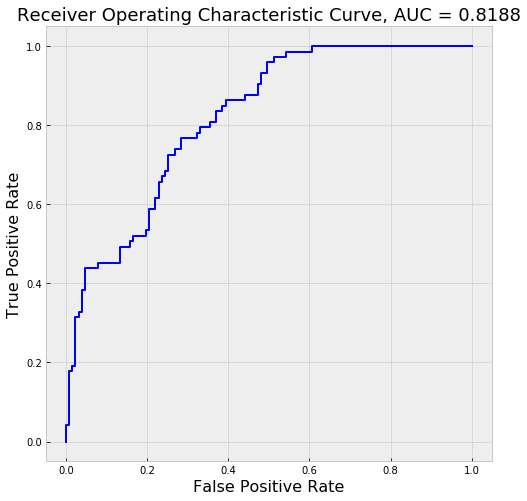

In [357]:
svc_pred_proba = svc.predict_proba(X_test_scaled)[:,1]
calc_roc(svc_pred_proba, y_test)

## Bayesian Logistic regression
First step is to define our model. We know the frequentist interpretition formula where Y= intercept + weights_i*parameter_i + error.and this can be represented by logit function, The logit function is the natural log of the odds that Y equals one of the categories.  For mathematical simplicity, we’re going to assume Y has only two categories and code them as 0 and 1.
The objective is to learn the "best" $\beta$ values which generally means those that are the most likely given a set of inputs and outputs. Logistic Regression calculates the values of $\beta$ using an iterative procedure of Maximum Likelihood Estimation.

$$\text{logit} = \beta_0 + \beta_1(\text{Pregnancies}) + \beta_2(\text{Glucose}) + \beta_3(\text{BloodPressure}) + \beta_4(\text{SkinThickness}) + \beta_5(\text{Insulin}) + \beta_6(\text{BMI}) + \beta_7(\text{DiabetesPedigreeFunction}) + \beta_8(\text{Age}) + \epsilon$$

The log odds can then be converted to a proability of the output:

$$p = \frac{1}{1 + e^\text{-logit}}$$

#### In contrast, the Bayesian Framework assumes that the likelihood of the data is drawn from a distribution. For classification with a binary outcome, this is a bernoulli distribution:

 $$p(Diabetes | Features) = \prod^{n}_{i=1} p_{i}^{y} (1 - p_{i})^{1-y_{i}}$$

The objective is to find the posterior probability distribution of the model parameters given the inputs and outputs.  calculating the exact posterior for the model parameters is intractable with continuous variables, and so we use Monte Carlo sampling methods. This means that we draw repeated samples from the posterior in order to approximate the posterior. Generally this is done with some form of a Markov Chain Monte Carlo algorithm, in which the next state is dependent only a bounded subset of the current state and past states (depending on the order of the chain). In the Bayesian Framework, the end result of linear regression is not a single point estimate for the "best" model parameters, but rather an entire distribution of potential model parameters representing our uncertainty about the true values.

In the Bayesian method, not only are the log odds assumed to be generated from a distribution, but so are the model parameters. If we have an idea about the parameters, we can encode this in the priors, or we can let the data speak and choose non-informative priors. Usually this means a normal distribution with a wide standard devivation for $\beta$. In the case of infinite data, the priors will be completely washed out by the data likelihood. There are two primary advantages to the Bayesian method: Priors: if we have information about the model parameters, we can inject it into the model, Posterior distributions: the result is a distribution for the model parameters instead of a point estimate


We can use the mean of the parameter distributions if we want to obtain a single "most likely" prediction by calculating the log odds and then converting to a probability, but we can also express a range of probabilities. As the amount of training data increases, the uncertainty in the model parameters should decrease. In the case of limited data, Bayesian methods can be a better way to quantify uncertainty because the possible distribution of parameters will be wide and the standard deviation of the log odd distribution will be large. Although frequentist logistic regression can include confidence intervals, Bayesian methods can provide a more inuitive display of uncertainty in the cases of limited data.

The end result of "fitting" the model by drawing samples from the posterior will be a distribution for each $\beta$ model weight. The distribution can be used to make predictions and to examine the effects on the outcome of changing the value of different input variables (sensitivity analysis). First, we will build up the model and sample from the posterior, and then we will thoroughly interpret the modeling results. Additionally, we can make predictions and compare the results to standard machine learning models, although the benefit of Bayesian Methods is not so much in the accuracy, as in the interpretability of the results of the modeling.

#### Distribution? Bernaulli? why?
we will use all eight features. We create the model using the formula defined above and then draw samples from the posterior using the No-UTurn Sampler. This is a variation of the Metropolis-Hastings algorithm, we have discussed MH algo in detail in another notebook. How the algorithm works? They sample random values from the posterior with the next value dependent only on the current state (or a bounded subset of previous states).

The data likelihood is a Bernoulli Variable because it satisfies the following three conditions:

Outcome is binary: 0 for does not have diabetes and 1 for has diabetes
Trials are independent of each other.
The probability of the outcome does not change with each trial.

If we have some prior knowledge, we can encode that if the priors for the $\beta$ coefficients, or we can use the default priors in PyMC3. The default priors for regressors (the explanatory variables) are normal with the distribution $N(0, 10^{6})$ and the default prior for the Intercept is a flat distribution. In the call to create our model, we will pass in the formula, our training data, and the distribution to use for the response variable, which is a Bernoulli distribution.

### Visualisation for the traces/plots
#### Trace plot
The trace plot shows all the samples drawn from all the variables. Note for each plot there are two traces, each trace represents the chain, here we are using 2 chains hence two curves/traces in each plot. 
#### Forest plot 
This shows the distribution of the sampled variables with the 95% credible interval (not similar to the confidence interval, in frequentist analysis). This is one of the benefits of Bayesian Inference: the model returns uncertainty measures, which represent that any model is really only a guess about the state of the 

In [358]:
# Shows the trace with a vertical line at the mean of the trace
def plot_trace(trace):
    # Traceplot with vertical lines at the mean value
    ax = pm.traceplot(trace, figsize=(12, len(trace.varnames)*1.5),
                      lines={k: v['mean'] for k, v in pm.summary(trace).iterrows()})
    
    '''plt.rcParams['font.size'] = 12
    # Labels with the mean value
    for i, mn in enumerate(pm.summary(trace)['mean']):
        ax[i, 0].annotate('{:0.2f}'.format(mn), xy = (mn, 0), xycoords = 'data', size = 8,
                          xytext = (5, 10), textcoords = 'offset points', rotation = 90,
                          va = 'bottom', fontsize = 'large', color = 'red')'''

In [359]:
for k, v in pm.summary(trace_robust).iterrows():
    print(k, v['mean'] )

Intercept -8.87
Pregnancies 0.113
Glucose 0.036
BloodPressure -0.018
SkinThickness -0.002
Insulin -0.001
BMI 0.11
DiabetesPedigreeFunction 0.842
Age 0.018


In [360]:
formula = [' %s + ' % variable for variable in X.columns]
formula.insert(0, 'y ~ ')
print(formula)
formula = ' '.join(''.join(formula).split(' ')[:-2])
formula

['y ~ ', ' Pregnancies + ', ' Glucose + ', ' BloodPressure + ', ' SkinThickness + ', ' Insulin + ', ' BMI + ', ' DiabetesPedigreeFunction + ', ' Age + ']


'y ~  Pregnancies +  Glucose +  BloodPressure +  SkinThickness +  Insulin +  BMI +  DiabetesPedigreeFunction +  Age'

In [361]:
# Create version of the training data with labels
X_with_labels = X.copy()
X_with_labels['y'] = y

In [362]:
with Model() as model:
    family = pm.glm.families.Binomial()
    pm.glm.GLM.from_formula(formula, X_with_labels, family=family)
    
    # Using the no-uturn sampler
    sampler = pm.NUTS()

    trace_robust = sample(draws=2000, step=sampler, cores=2)

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Age, DiabetesPedigreeFunction, BMI, Insulin, SkinThickness, BloodPressure, Glucose, Pregnancies, Intercept]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 1322 seconds.


In [363]:
pm.summary(trace_robust)

mean     sd  hpd_3%  hpd_97%  mcse_mean  mcse_sd  \
Intercept                -9.509  0.987 -11.381   -7.692      0.019    0.014   
Pregnancies               0.118  0.040   0.042    0.191      0.001    0.000   
Glucose                   0.042  0.005   0.034    0.052      0.000    0.000   
BloodPressure            -0.020  0.010  -0.040   -0.001      0.000    0.000   
SkinThickness            -0.006  0.015  -0.035    0.021      0.000    0.000   
Insulin                  -0.002  0.001  -0.004    0.000      0.000    0.000   
BMI                       0.121  0.022   0.080    0.161      0.000    0.000   
DiabetesPedigreeFunction  0.778  0.373   0.060    1.456      0.006    0.005   
Age                       0.014  0.011  -0.008    0.035      0.000    0.000   

                          ess_mean  ess_sd  ess_bulk  ess_tail  r_hat  
Intercept                   2586.0  2527.0    2626.0    2379.0    1.0  
Pregnancies                 3499.0  3377.0    3501.0    3077.0    1.0  
Glucose                     2359.0  2314.0    2389.0    2338.0    1.0  
BloodPressure               3128.0  2718.0    3145.0    2701.0    1.0  
SkinThickness               2878.0  1963.0    2898.0    2679.0    1.0  
Insulin                     3215.0  2779.0    3227.0    2352.0    1.0  
BMI                         2464.0  2401.0    2479.0    2518.0    1.0  
DiabetesPedigreeFunction    4055.0  3256.0    4070.0    2518.0    1.0  
Age                         3562.0  3511.0    3569.0    3157.0    1.0

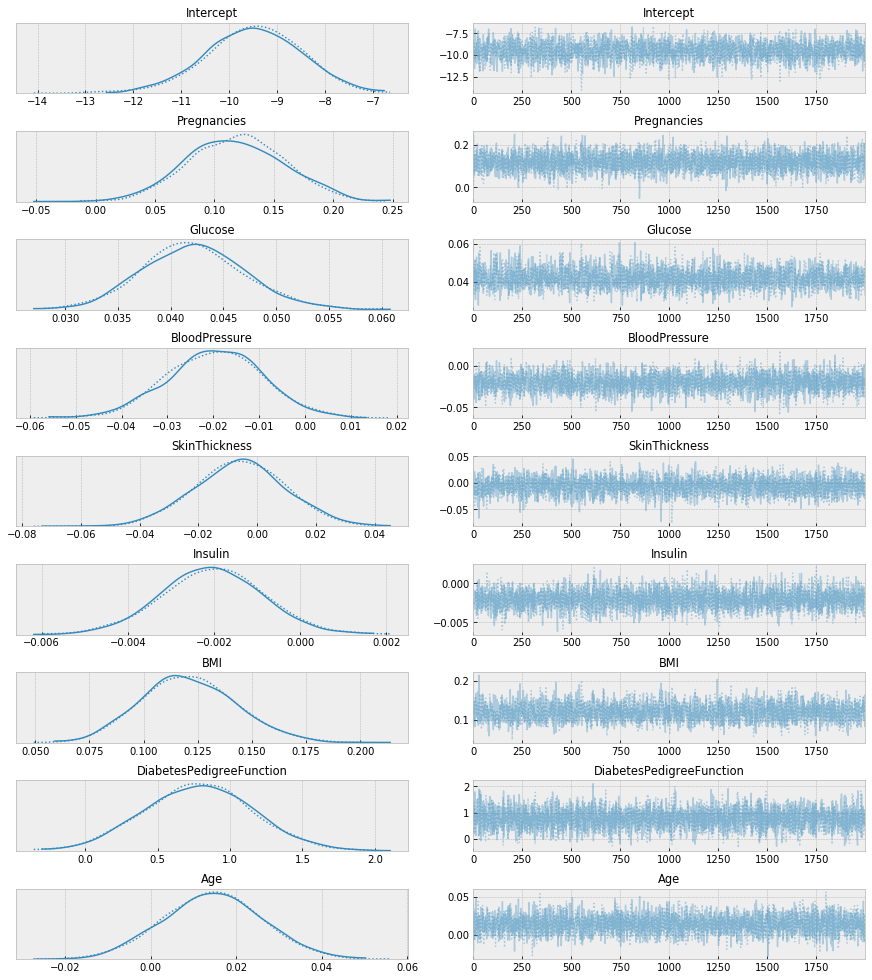

In [364]:
plot_trace(trace_robust);

The traceplot summaries what is occurring behind the scenes with Markov Chain Monte Carlo. The left shows the final approximate posterior distribution for the model parameters, and the right shows the complete trace from the sampling procedure.

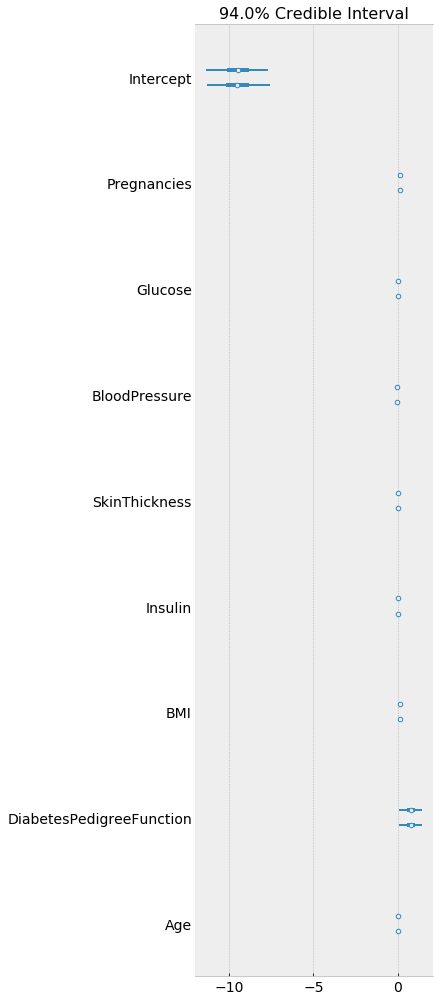

In [365]:
figsize(10, 12)
pm.forestplot(trace_robust);

What we see over here is the uncertainities are large for diabetic pedigree function and intercept. this means the model is not sure about the model parameters of these variables, hence larger uncertainities. In next step we are going to see if we keep the parameter 

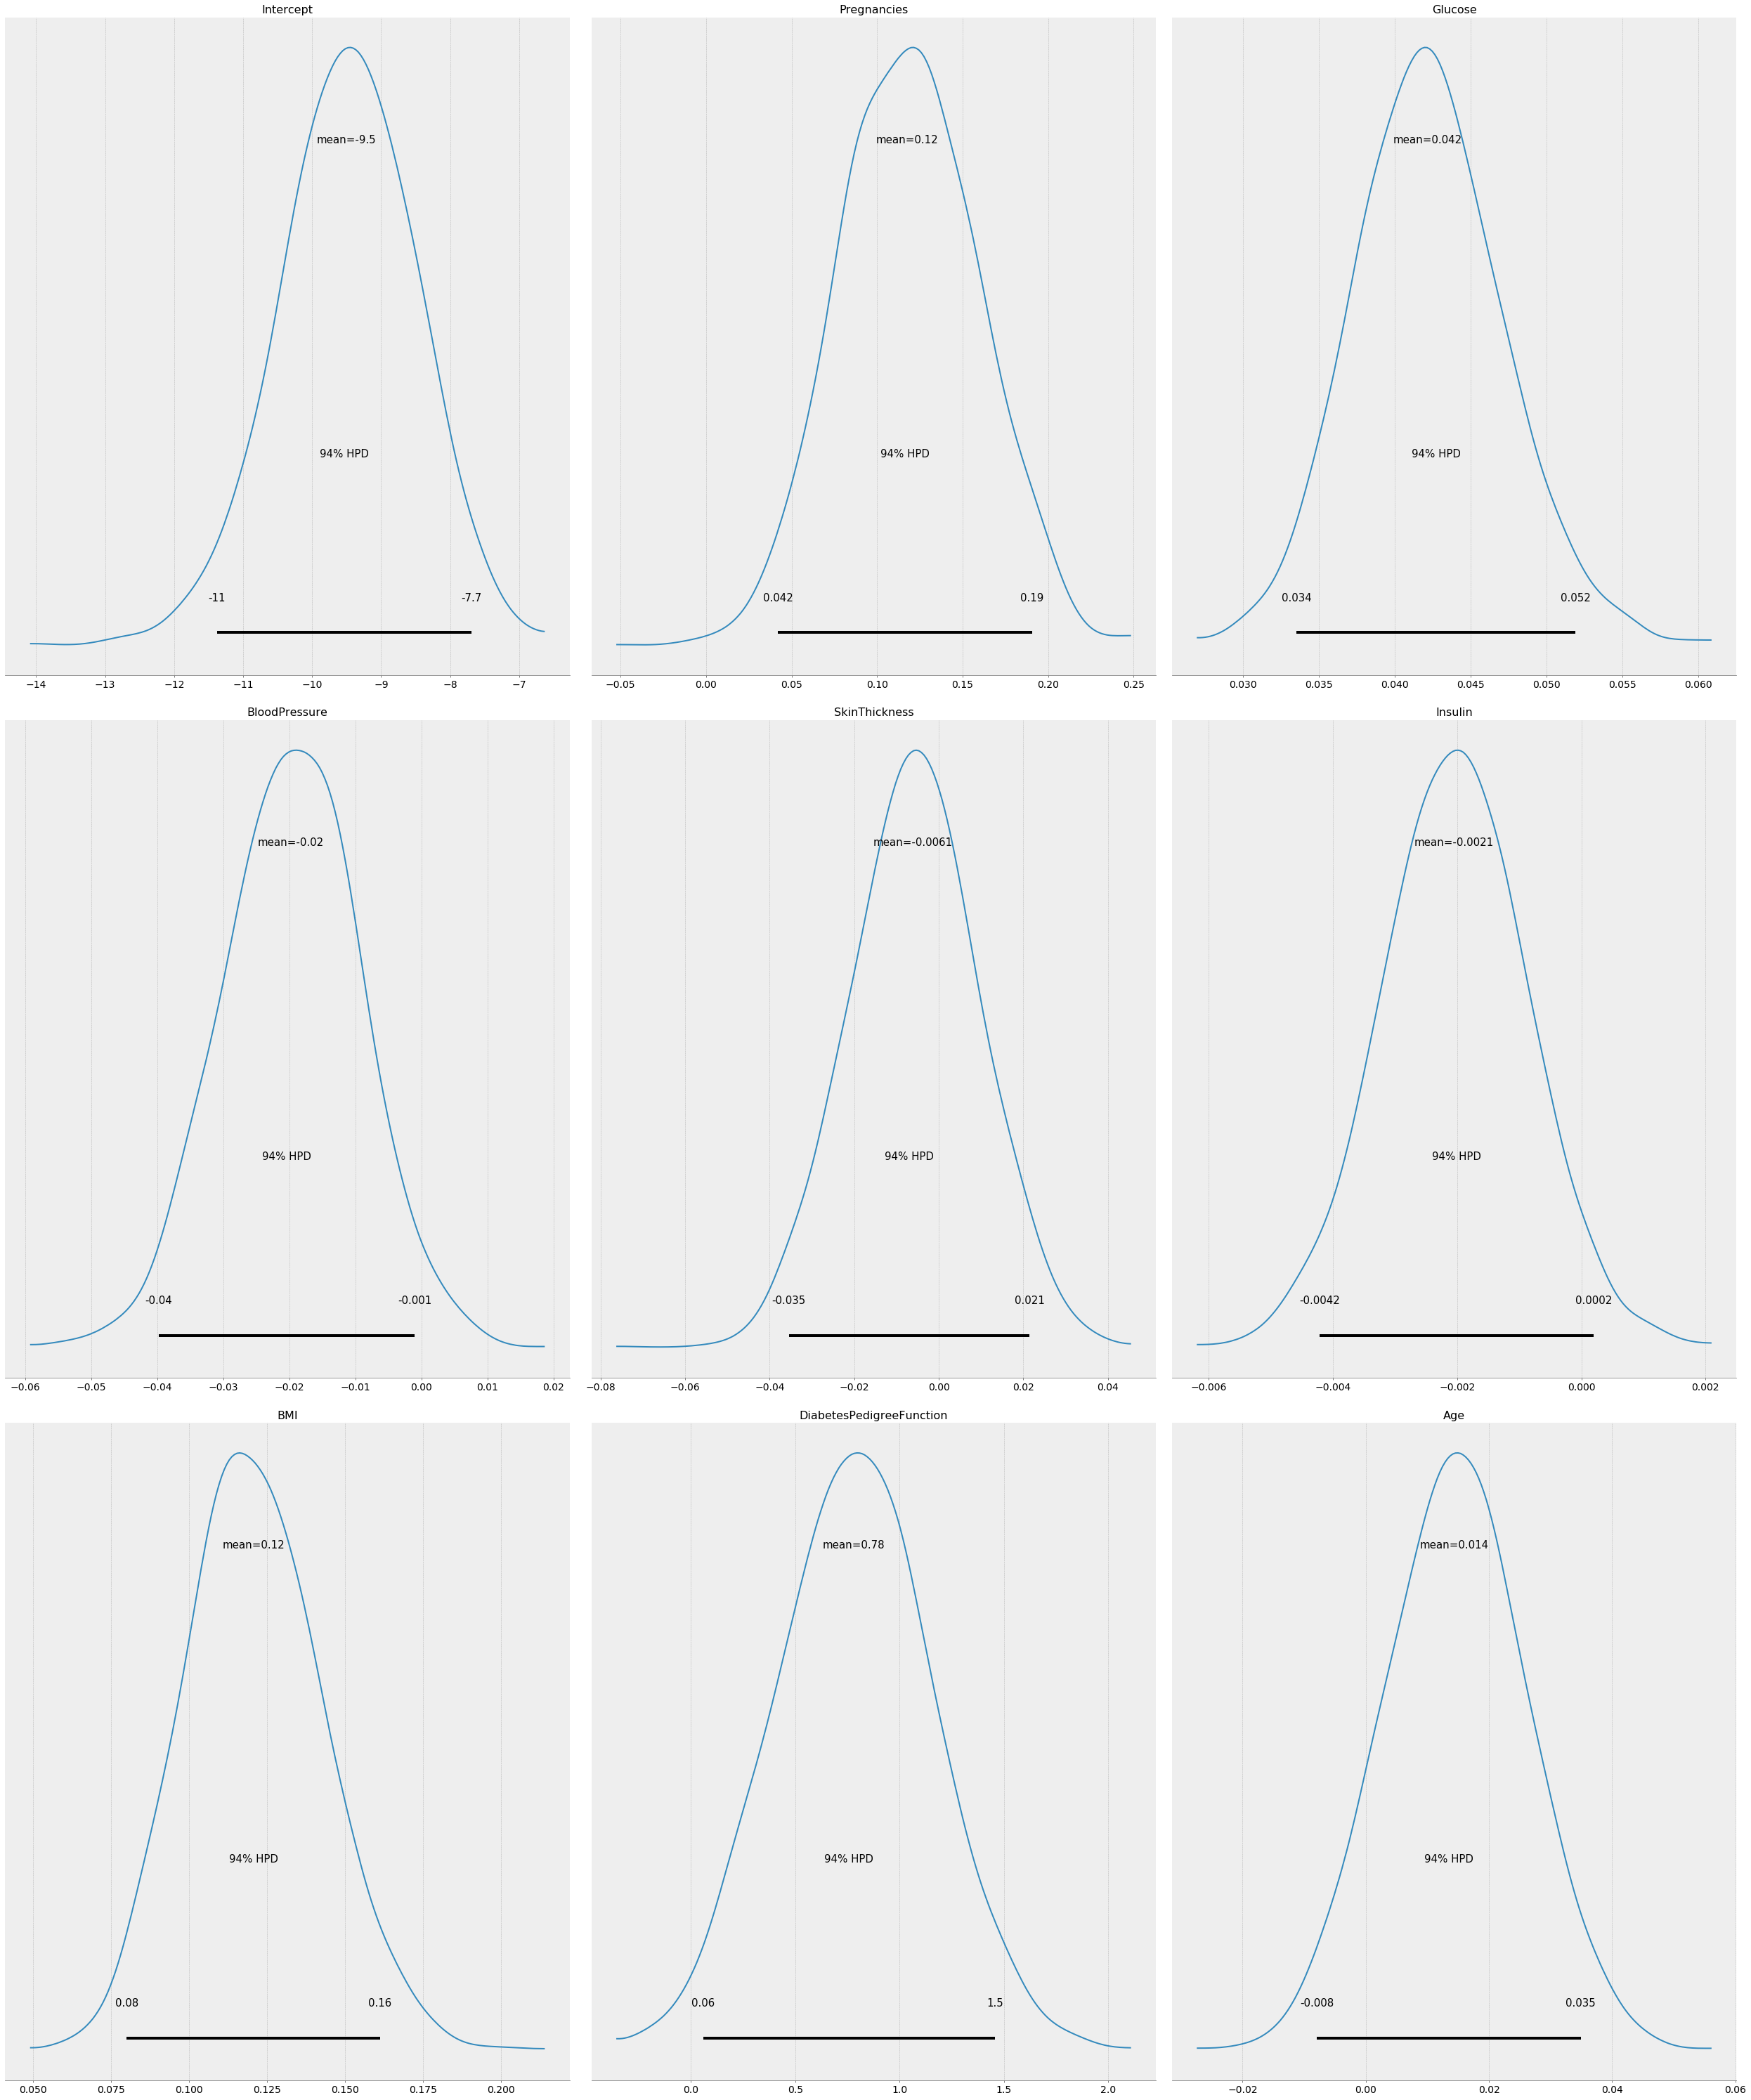

In [366]:
pm.plot_posterior(trace_robust)
plt.show()

What we are doing here is: fixing the values of every parameter in the equation except the query variable and intercept, plotting the posterior. The reason for doing this is to see how the change in the query variable will affect the probability of gettign diabeties. and we can also see the spread of the traces, which we can also see withthe uncertainities in the description provided above.
We are fixing the values of the paprameters by taking the median of that variable from original data
NOTE: you have to write function for "lm" in plot of linear model. because leaving it blank is not supporting it. moreover you defined the posterior as the lpgit function in it.

In [367]:
def model_effect(query_var, trace, X):
   # All variables except the query variable are held constant
    steady_vars = list(X.columns)
    steady_vars.remove(query_var)
    
    # using the definition of lm when we got the error:
    # lm = lambda x, sample: sample['Intercept'] + sample['x'] * x
    # we cant leave lm as none because we want to fix the other variables and give a definition of probability in terms of 
    # logit as we defined before
    
    # Linear model 
    def lm(x, samples):
        denominator = samples['Intercept'] + samples[query_var] * x
        
        # Hold all other variables at the median value
        for var in steady_vars:
            denominator += samples[var] * X[var].median()
        denominator = (1 + np.exp(-denominator))
        probs = 1 / denominator 
        
        return probs
    
    figsize(8, 8)
    
    # Range over which to evaluate the query variable
    var_min = X[query_var].min()
    var_max = X[query_var].max()
    
    # Plot the linear model across a range of the query var
    pm.plot_posterior_predictive_glm(trace, lm = lm, eval=np.linspace(var_min, var_max, 100), samples=100, color='blue', alpha = 0.4, lw = 2)
    
    # Label the image
    plt.xlabel('%s' % query_var, size = 18)
    plt.ylabel('P(Diabetes)', size = 18)
    plt.title("%s Effect on Posterior Probability" % query_var, size = 20)
    plt.xticks(size = 14); plt.yticks(size = 14)
    plt.show()

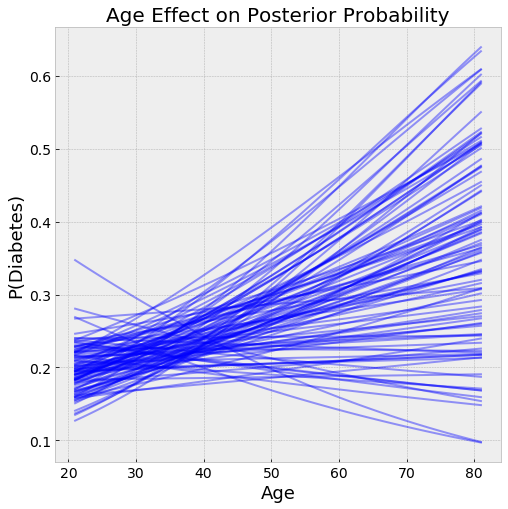

In [368]:
model_effect('Age', trace_robust, X)


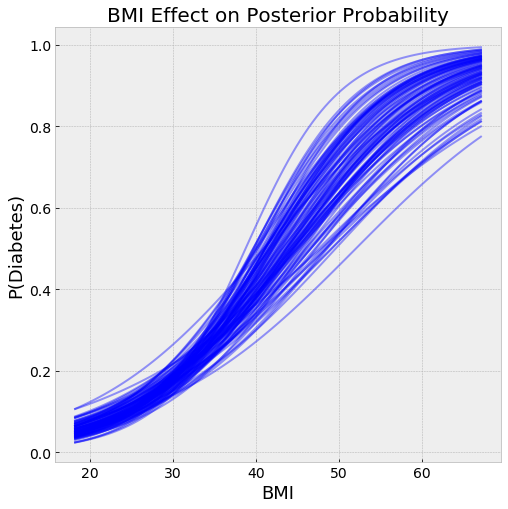

In [369]:
model_effect('BMI', trace_robust, X)


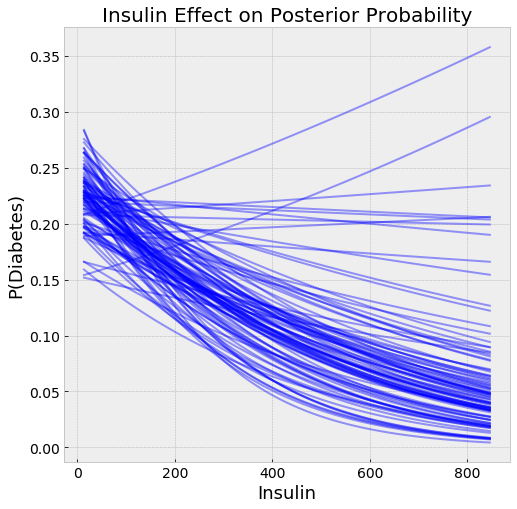

In [385]:
model_effect('Insulin', trace_robust, X)


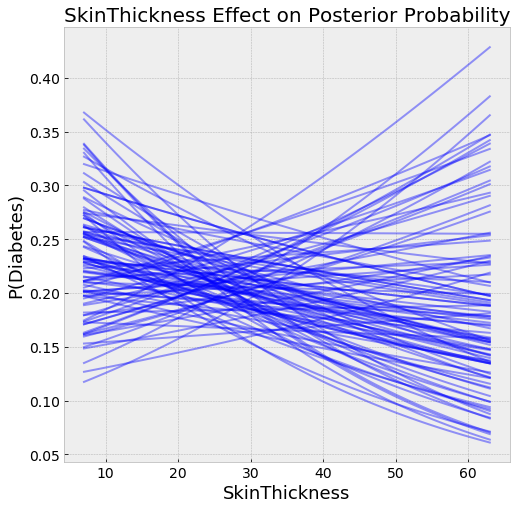

In [386]:

model_effect('SkinThickness', trace_robust, X)
## lot of uncertainity here

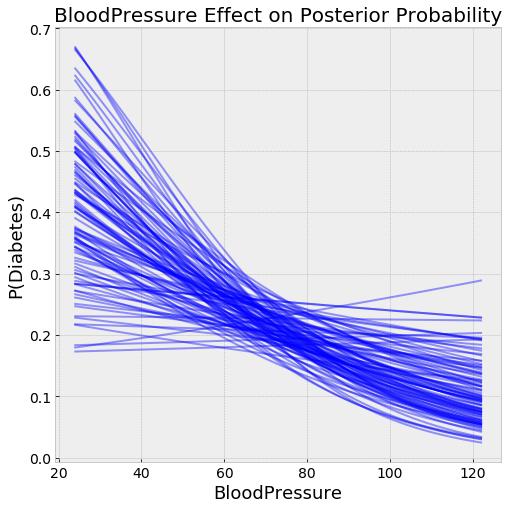

In [370]:
model_effect('BloodPressure', trace_robust, X)

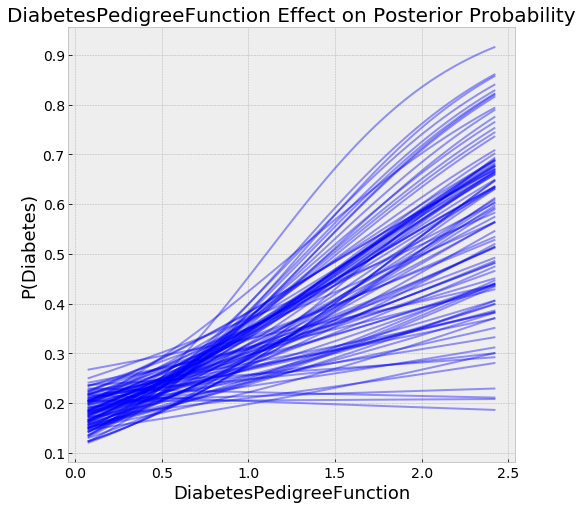

In [371]:
model_effect('DiabetesPedigreeFunction', trace_robust, X)


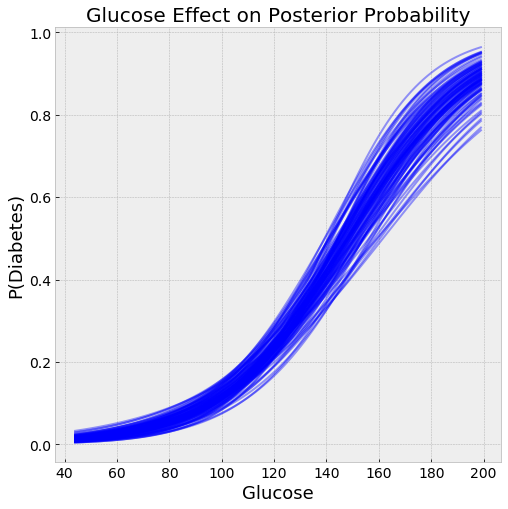

In [372]:
model_effect('Glucose', trace_robust, X)

### Take away
1. Age has a positive effect on the probability of diabetes on average. The spread of lines indicates the uncertainty in the estimate of the age effect in the model.
2. BMI and Glucose both indicates that the higher the value higher the chance of diabetes. Glucose is highly correlated with diabates
3. BP range goes from 20-120, higher means lower diabetes


### Next step
1. Comparing models fo different ML
2. Prediction using the mean values of "weight's/parameter's" trace

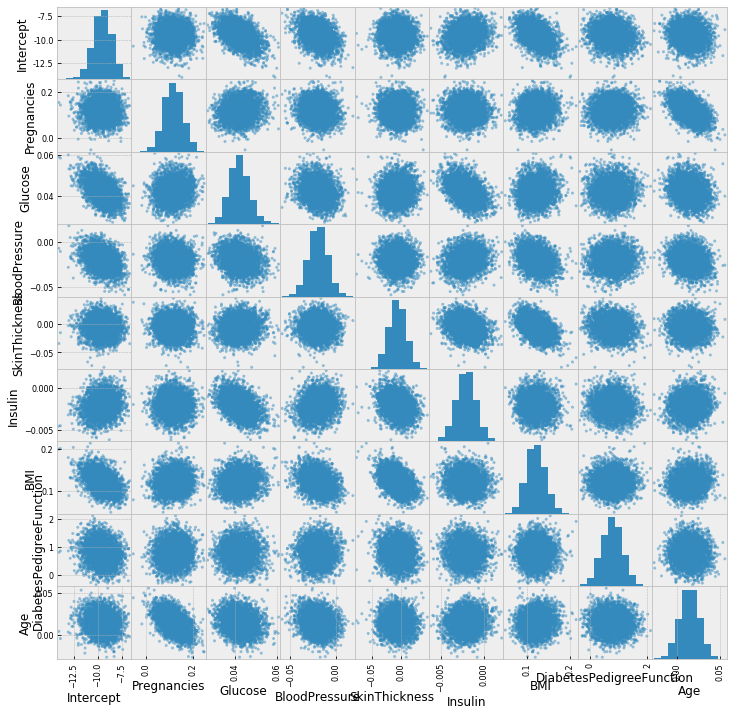

In [373]:
scatter_matrix(trace_to_dataframe(trace_robust), figsize=(12,12));

Now we need to make predictions. For that we need the single value of each weights to test it on the data. We can also use the values in utr traces and can comeup with the range od estimates with teh uncertainities in the prediction.
But we are foing to calculate the ROC curve using the mean value os the weights as most likely estimates. and hence comparing it with otehr ML models
Steps:
1. Writing a function to calculate the probability ( from logit, check the formula above)
2. Calculating the AUC for bayesian analysis and comparing it with other ML functions
3. Writing functions to get the probabilities of the test cases/specific patients

In [374]:
# Find a single probabilty estimate using the mean value of variables in a trace
def find_probs(trace, data):
    
    # Find the means and std of the variables
    means_dict = {}
    std_dict = {}
    for var in trace.varnames:
        means_dict[var] = np.mean(trace[var])
        std_dict[var] = np.std(trace[var])    

    probs = []
    mean_array = np.array(list(means_dict.values()))
    
    # Need an intercept term in the data
    data['Intercept'] = 1
    data = data[list(means_dict.keys())]
    
    # Calculate the probability for each observation in the data
    for _, row in data.iterrows():
        # First the log odds
        logit = np.dot(row, mean_array)
        # Convert the log odds to a probability
        probability = 1 / (1 + np.exp(-logit))
        probs.append(probability)
        
    return probs

Accuracy of Model: 74.00%
F1 Score of Model: 0.5667


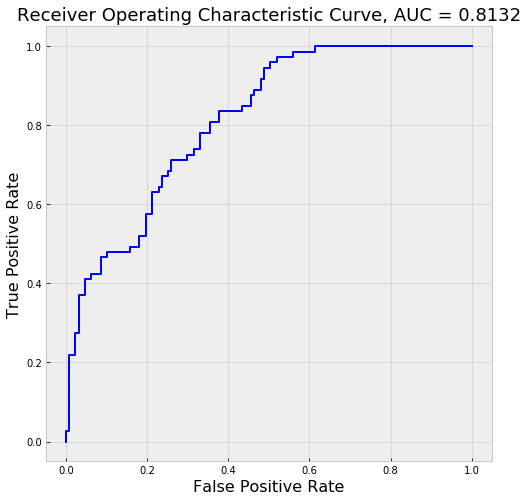

In [375]:
blr_probs = find_probs(trace_robust, X_test)

# Threshold the values at 0.5
predictions = (np.array(blr_probs) > 0.5)
calc_metrics(predictions, y_test)
calc_roc(blr_probs, y_test)


We are comparing all the ML models

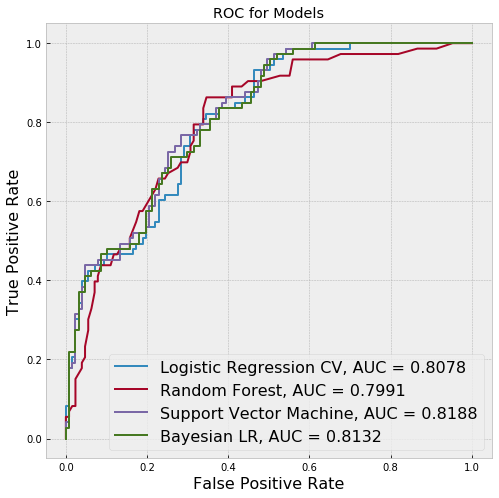

In [376]:

labels = ['Logistic Regression CV', 'Random Forest', 'Support Vector Machine',
         'Bayesian LR']

plt.figure(figsize = (8, 8))

for i, probs in enumerate([lr_pred_proba, rf_pred_proba, svc_pred_proba, blr_probs]):
  fpr, tpr, thresholds = roc_curve(y_test, probs)
  auc = roc_auc_score(y_test, probs)
  plt.plot(fpr, tpr, label = '%s, AUC = %0.4f' % (labels[i], auc))
  
plt.xlabel('False Positive Rate', size = 16)
plt.ylabel('True Positive Rate', size = 16)
plt.legend(prop={'size': 16})
plt.title('ROC for Models')
plt.show();

# model predictions (bayesian only)

Now we have the model parameters with the traces and we are going to use that to get the probabilities
1. We do this by using all the samples of the model parameters from the posterior distribution instead of a single value. The result is a distribution of predictions which we can compare to the true value. Steps for doing that: 

2. calculating the probability using all the trace values of each parameter.
3. Printing (using kdeplot) and the median probabaility, credible intervals.
4. We are also plotting the trace values for the variabled for that particular patient/observation as we want to see whats going wrong for the cases where our prediction is wrong, we want to check which variable is driving the wrong outcome.

In [381]:
def investigate_pat(trace, obs, true_label):
    var_dict = {}
    # Get a range of values for the model parameters
    
    for var in trace.varnames:
        var_dict[var]= trace[var][-1000:]
    
    var_list = list(var_dict.keys())
    
    # Need to add the intercept to the data
    obs['Intercept'] = 1 
    # we took intercept as 1 because we wanna multiply out trace values by 1 only as we dont have any defined values
    obs = obs[var_list]
    
    # Calculate the log odds with the parameters
    logits = np.dot(obs.values, np.array(list(var_dict.values())))
    
    # Convert to probabilities
    probs = 1 / (1 + np.exp(-logits))
    #print(len(probs))
    
    # Print the information about the prediction
    print('\n\nMedian estimated probability: {:0.2f}'.format(np.percentile(probs, 50)))
    print('5% estimated probability:     {:0.2f}'.format(np.percentile(probs, 5)))
    print('95% estimated probability:    {:0.2f}\n\n'.format(np.percentile(probs, 95)))

    figsize(6,6)
    # Density Plot of the Probabilities
    kde2 = sns.kdeplot(probs, label = 'pdf')
    
    # adding the vertical lines for percentiles/credible intervals
    plt.vlines([np.percentile(probs,5), np.percentile(probs,95)],ymin = 0, ymax = kde2.get_ybound()[1], 
               colors = ['red'], linestyles = '--', label = '5% and 95% CI')
    plt.xlabel('P(Diabetes)', size = 18); plt.ylabel('Density', size =18);
    
    plt.title('True Class: %s' % ('Diabetes' if true_label == 1 else 'No Diabetes'), size = 18);
    plt.legend(prop={'size': 12});
    plt.show()
    
    print('Raw Data for that observation\n\n', obs)
    
    figsize(12,12)
    for i , var in enumerate(X_test.columns):
        if var != 'Intercept':
            ax= plt.subplot(4, 2, i+1)
            kde2 = sns.kdeplot(X_test[var], color = 'black')
            plt.vlines([obs[var]],ymin = 0, ymax = kde2.get_ybound()[1], colors = ['green'], linestyles = '--', label = '')
            ax.set_xlabel(var)
            ax.set_ylabel('Density')

In [380]:
for i , var in enumerate(X_test.columns):
        if var != 'Intercept':
            print(var)

Pregnancies
Glucose
BloodPressure
SkinThickness
Insulin
BMI
DiabetesPedigreeFunction
Age




Median estimated probability: 0.21
5% estimated probability:     0.14
95% estimated probability:    0.30




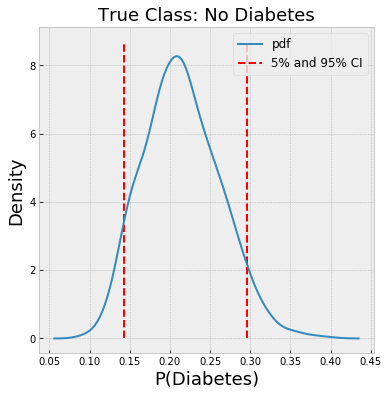

Raw Data for that observation

 Intercept                     1.000
Pregnancies                   4.000
Glucose                     110.000
BloodPressure                92.000
SkinThickness                23.000
Insulin                      30.500
BMI                          37.600
DiabetesPedigreeFunction      0.191
Age                          30.000
Name: 10, dtype: float64


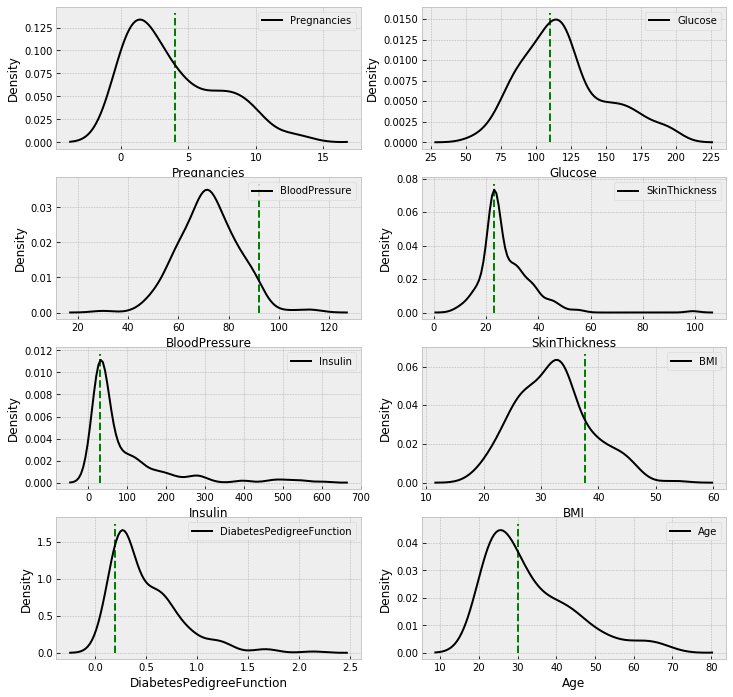

In [382]:
test_index = 5
investigate_pat(trace_robust, X_test.iloc[test_index, :], y_test.values[test_index])

In the above case the prediction is what we expected but we want to investigate more on the cases where prediciton is not what the observation says. we want to see what parameters are affecting the wrong observation

## Investigating on wrong prediction cases



Median estimated probability: 0.30
5% estimated probability:     0.24
95% estimated probability:    0.37




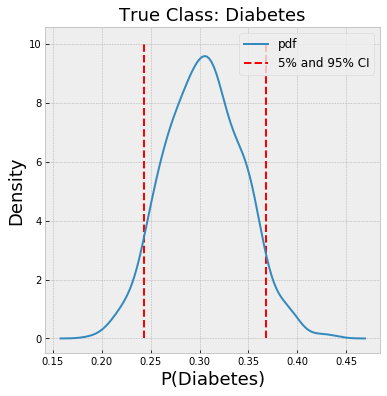

Raw Data for that observation

 Intercept                     1.000
Pregnancies                   1.000
Glucose                     122.000
BloodPressure                64.000
SkinThickness                32.000
Insulin                     156.000
BMI                          35.100
DiabetesPedigreeFunction      0.692
Age                          30.000
Name: 326, dtype: float64


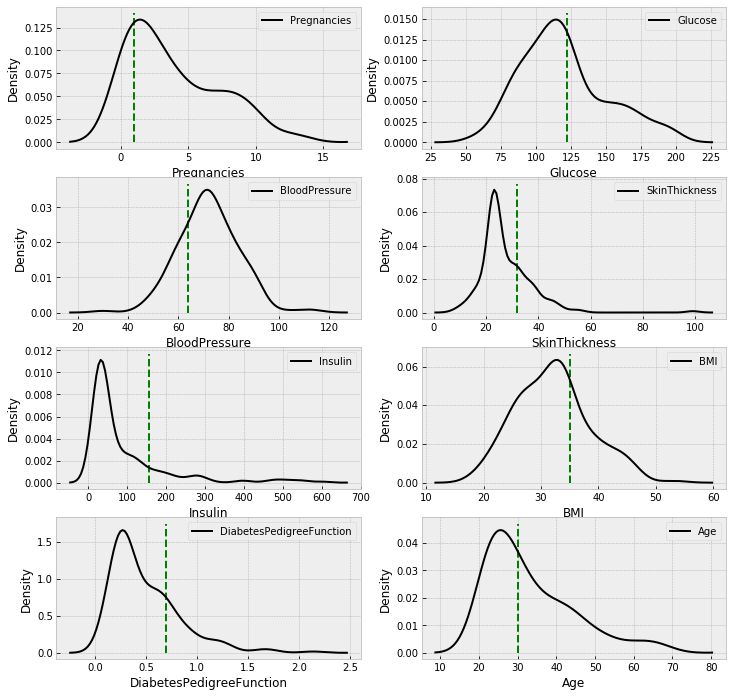

In [383]:
test_index = 100
investigate_pat(trace_robust, X_test.iloc[test_index, :], y_test.values[test_index])

wrong prediciton. im comparing each trace with the traces that we plotted in blue above where we are seeing the model effects of variables. Pointers for this case:
1. Age looks fine here (no diabetes side)
2. Glucose id pointing towards no diabetes
3. pedifree function si pointing towards no diabetes

NOTE: the most driving factors are Diabetespedigree function and gluse as their parameters/weights are more compared to others, here these two parameters are pointing towards lower lower diabetes hence our result is focused there

# Future work:
1. We can work on different models where we can take only two varibales or 3 variables and see how accurate is the model. The aim of ML is to create most accurate model that can correctly map the inputs to outputs, maybe model with fewer inputs will be easier to interpret a dn maybe performance is same or better compared to the complicated model where we are taking all the features mentioned in the data,  

2. Visualising decision boundary and working on that, its a better thing to do when you are working on eliminating features which are not playing important part. (see below, its a non linear problem )



# Conclusion
Here we did work on exploring the bayesian logistic regression for mML supervised classification task. we compared our results with multiple machine learnign models. The two benifits of bayesian approaches are: Encoding domain knowledge in the models using prior and determinign posterior distribution for the model paramters.
The we checked the model results to determine the effect of altering one varibale while holding the other variables with the mean value of the trace.

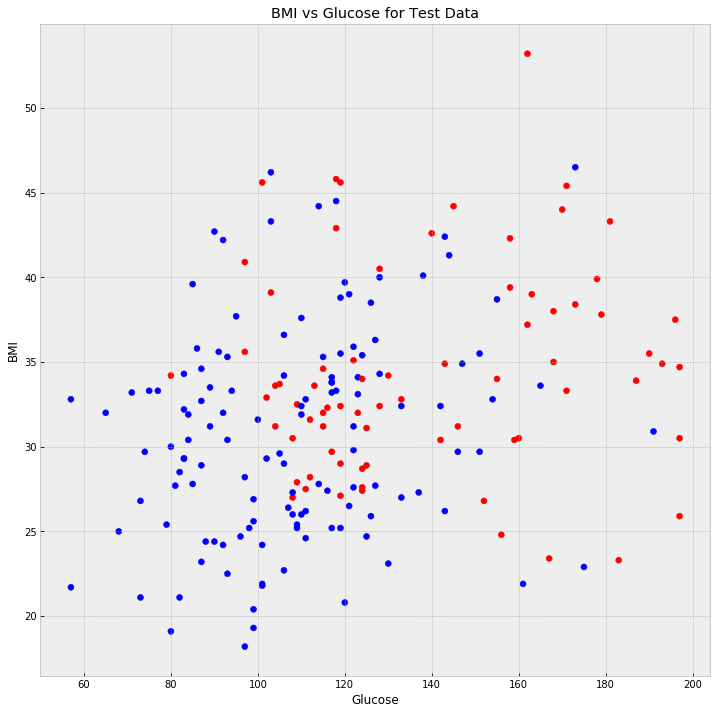

In [392]:
X_test['color'] = ['red' if y_test.values[i] == 1 else 'blue' for i in range(len(y_test))]
plt.scatter(X_test['Glucose'], X_test['BMI'], color = X_test['color'])
plt.ylabel('BMI'); plt.xlabel('Glucose'); plt.title('BMI vs Glucose for Test Data');

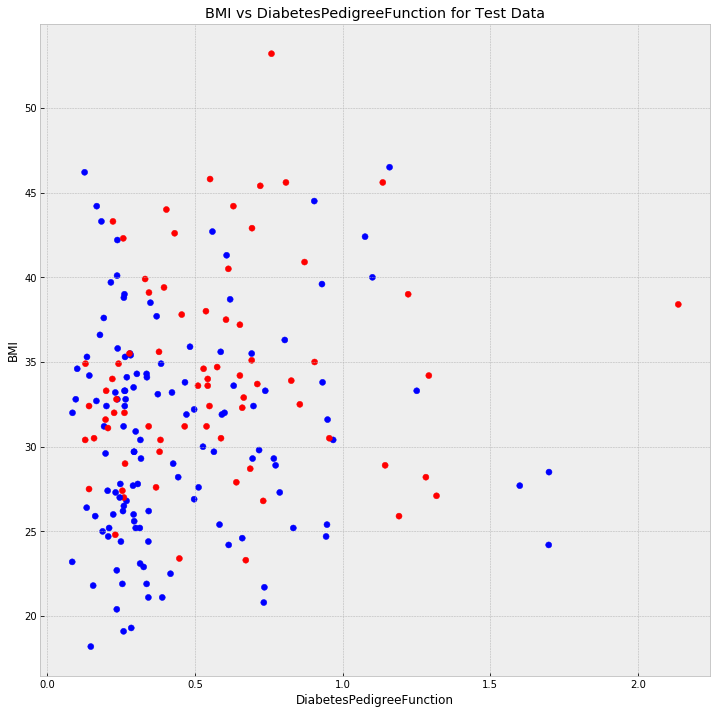

In [393]:
X_test['color'] = ['red' if y_test.values[i] == 1 else 'blue' for i in range(len(y_test))]
plt.scatter(X_test['DiabetesPedigreeFunction'], X_test['BMI'], color = X_test['color'])
plt.ylabel('BMI'); plt.xlabel('DiabetesPedigreeFunction'); plt.title('BMI vs DiabetesPedigreeFunction for Test Data');

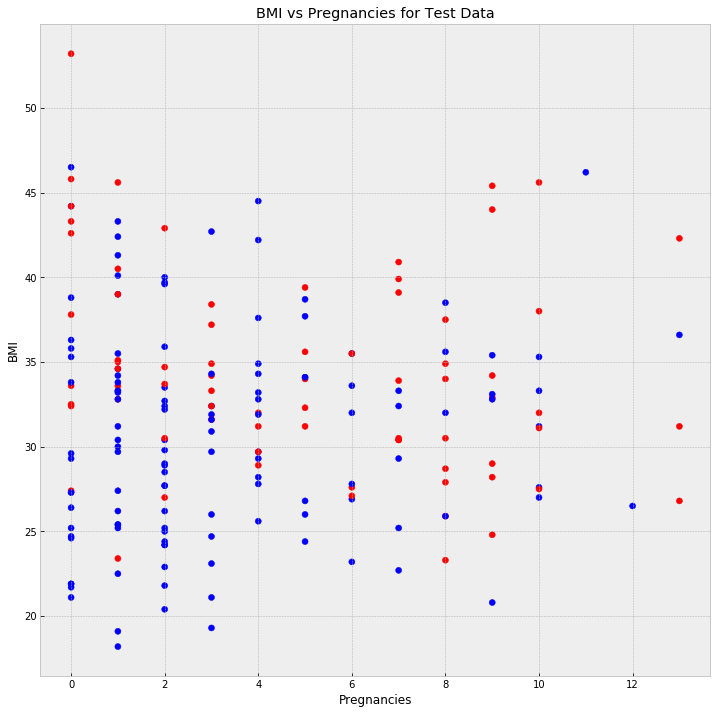

In [394]:
X_test['color'] = ['red' if y_test.values[i] == 1 else 'blue' for i in range(len(y_test))]
plt.scatter(X_test['Pregnancies'], X_test['BMI'], color = X_test['color'])
plt.ylabel('BMI'); plt.xlabel('Pregnancies'); plt.title('BMI vs Pregnancies for Test Data');